In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import nltk
import json
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('drive/MyDrive/ENGI 4800/author-capstone-20K-limit.csv', sep = '|', header = None).dropna()
df = pd.read_csv('drive/MyDrive/ENGI 4800/data/df_converted.csv',header = 0).dropna()[['pii','Converted_Section_Content','Authors']]
m,n = df.shape
df.index = np.arange(m)
df.columns = ['pii','Section_content','Authors']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16949 entries, 0 to 16948
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pii              16949 non-null  object
 1   Section_content  16949 non-null  object
 2   Authors          16949 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [ ]:
df['Section_content'][1]

'The authors confirm contribution to the paper as follows: study conception and design:  #57221288000 ,  #7006423551 ,  #56323815300 ; data collection:  #56323815300 ,  #57139150400 ,  #57221288000 ; analysis and interpretation of results:  #57221288000 ,  #7006423551 ; draft manuscript preparation:  #57221288000 ,  #7006423551 . All authors reviewed the results and approved the final version of the manuscript.'

## Split into sentences and remove unrelated sentences


In [ ]:
vars = ['#1','#2','#3','#4','#5','#6','#7','#8','#9', 'all', 'All', 'author', 'Author']

In [ ]:
df_converted = df.copy()
df_converted['Sentences'] = [[] for i in range(m)]
total = 0
related = 0
# How many sentences are actually related (with authors)
for i in range(m):
  sen_lis = df['Section_content'][i].replace(';', '.').split('. ')
  for sen in sen_lis:
    total += 1
    flag = False
    for item in vars:
      if item in sen:
        flag = True
    if flag:
      df_converted['Sentences'][i].append(sen)
      related +=1
      pass
    else:
      if i<=10:
        print(sen)
        print(df['Section_content'][i])
        print(df['pii'][i])

Roles/Writing - original draft
 #57189385591 , MD: Conceptualization; Roles/Writing - original draft; Formal analysis  #57213472596 , MD: Data curation  #57218421000 : Investigation; Methodology  #57213472596   #56406209000 : Roles/Writing - original draft  #57218419661  Hoti MBBS: Data Collection  #6602435498 , MD: Validation; Critical Review  #6507283777 , FRCP: Validation; Visualization David  #7006014406 , FACC: Supervision; Critical Review
S0002914920306883
Critical Review
 #57189385591 , MD: Conceptualization; Roles/Writing - original draft; Formal analysis  #57213472596 , MD: Data curation  #57218421000 : Investigation; Methodology  #57213472596   #56406209000 : Roles/Writing - original draft  #57218419661  Hoti MBBS: Data Collection  #6602435498 , MD: Validation; Critical Review  #6507283777 , FRCP: Validation; Visualization David  #7006014406 , FACC: Supervision; Critical Review
S0002914920306883


In [ ]:
related/total

0.860070291906668

In [ ]:
df_converted['Sention_converted'] = ''
for i in range(m):
  df_converted['Sention_converted'][i] = ". ".join(df_converted['Sentences'][i])

In [ ]:
df_converted
df_converted.to_csv('drive/MyDrive/ENGI 4800/df_converted_splitted.csv')

## Remove stop words and punctuations



In [ ]:
from nltk.corpus import stopwords
nltk.download("stopwords",quiet=True)
stop_words = set(stopwords.words('english'))

df_copy = df.copy()

# Remove stop words
for i in range(m):
    sentence = df_converted['Sention_converted'][i].split()
    df_copy['Section_content'][i] = ' '.join([word.lower() for word in sentence if word not in stop_words and len(word)>1])


In [ ]:
# Remove punctuations
import string
punctuations = string.punctuation

for i in range(m):
    sentence = df_copy['Section_content'][i]
    df_copy['Section_content'][i] = sentence.translate(str.maketrans('', '', string.punctuation.replace('#','')))

In [ ]:
# Get the counts for all words
vocab = {}
for i in range(m):
    sentence = df_copy['Section_content'][i].split()
    for word in sentence:
        vocab[word] = vocab.get(word, 0) + 1
vocab = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

In [ ]:
vocab_top30 = vocab[0:30]
vocab_top30

[('data', 21283),
 ('manuscript', 19354),
 ('analysis', 12947),
 ('writing', 11589),
 ('experiments', 10814),
 ('performed', 10313),
 ('authors', 8291),
 ('study', 7818),
 ('designed', 7806),
 ('editing', 7004),
 ('wrote', 6917),
 ('contributed', 6056),
 ('all', 5992),
 ('review', 5922),
 ('analyzed', 5495),
 ('design', 5426),
 ('draft', 5051),
 ('final', 5040),
 ('conceptualization', 5021),
 ('methodology', 4900),
 ('investigation', 4823),
 ('conceived', 4533),
 ('interpretation', 4151),
 ('acquisition', 4112),
 ('supervision', 4003),
 ('original', 3710),
 ('project', 3510),
 ('formal', 3368),
 ('paper', 3358),
 ('funding', 3214)]

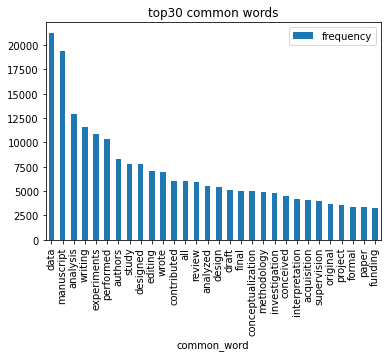

In [ ]:
# Print top 30 words histograms
df_common = pd.DataFrame(vocab_top30, columns=['common_word', 'frequency'])
df_common.plot(kind='bar', x='common_word', title='top30 common words')

In [ ]:
# Counts of sentences with different vocab size
vocab_size = {}
vb_length = []
for i in range(m):
    sentence = df_copy['Section_content'][i].split()
    v_s = len(set(sentence))
    vb_length.append(v_s)
    if v_s >= 115:
      print(" ".join(sentence))
    vocab_size[v_s] = vocab_size.get(v_s, 0) + 1
vocab_size = sorted(vocab_size.items(), key = lambda x: x[0], reverse = False)

In [ ]:
vocab_size[:10]

In [ ]:
df_voc = pd.DataFrame(vocab_size, columns=['content_size', 'frequency'])
df_voc.plot(kind='bar', x='content_size', title='histogram of content size',figsize=(24, 5))

## Stem


In [ ]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
df_stem = df_copy.copy()
for i in range(m):
    sentence = df_copy['Section_content'][i].split()
    Use porter stemmer to stem words
    df_stem['Section_content'][i] = ' '.join([porter.stem(word)\
                                              if not word.startswith('#')\
                                              else word\
                                              for word in sentence])

In [ ]:
# Get counts of all words after stemming
vocab_stem = {}
for i in range(m):
    sentence = df_stem['Section_content'][i].split()
    for word in sentence:
        vocab_stem[word] = vocab_stem.get(word, 0) + 1
vocab_stem = sorted(vocab_stem.items(), key = lambda x: x[1], reverse = True)

In [ ]:
vocab_stem_top30=vocab_stem[0:30]
vocab_stem_top30

In [ ]:
# Print top 30 frequent words after stemming
df_common_Stem = pd.DataFrame(vocab_stem_top30, columns=['common words', 'frequency'])
df_common_Stem.plot(kind='bar', x='common words', title='Top30 Common Words after stemming')

In [ ]:
# Counts of sentences with different vocab size after stemming
vocab_size_stem = {}
for i in range(m):
    sentence = df_stem['Section_content'][i].split()
    v_s = len(set(sentence))
    vocab_size_stem[v_s] = vocab_size_stem.get(v_s, 0) + 1
vocab_size_stem = sorted(vocab_size_stem.items(), key = lambda x: x[0], reverse = False)

In [ ]:
vocab_size_stem[:10]

In [ ]:
df_voc_stem = pd.DataFrame(vocab_size_stem, columns=['content_size', 'frequency'])
df_voc_stem.plot(kind='bar', x='content_size', title='histogram of content size after stemming',figsize=(24, 5))

## Removing names and initials

In [ ]:
# Removing names and initials 
df_remove_name = df_stem.copy()
for i in range(m):
    sentence = df_stem['Section_content'][i].split()
    df_remove_name['Section_content'][i] = ' '.join([word for word in sentence if not word.startswith('#')])

In [ ]:
df_remove_name

In [ ]:
# Get counts of all words after removing names and initials
vocab_remove_name = {}
for i in range(m):
    sentence = df_remove_name['Section_content'][i].split()
    for word in sentence:
        vocab_remove_name[word] = vocab_remove_name.get(word, 0) + 1
vocab_remove_name = sorted(vocab_remove_name.items(), key = lambda x: x[1], reverse = True)

In [ ]:
vocab_re_top30=vocab_remove_name [0:30]
vocab_remove_name [0:30]

In [ ]:
# Print top 30 frequent words after removing names and initials
df_common_re = pd.DataFrame(vocab_re_top30, columns=['common words', 'frequency'])
df_common_re.plot(kind='bar', x='common words', title='TOP 30 Common Words after removing author names')

In [ ]:
# Counts of sentences with different vocab size after removing names and initials
vocab_size_remove_name = {}
for i in range(m):
    sentence = df_remove_name['Section_content'][i].split()
    v_s = len(set(sentence))
    vocab_size_remove_name[v_s] = vocab_size_remove_name.get(v_s, 0) + 1
vocab_size_remove_name = sorted(vocab_size_remove_name.items(), key = lambda x: x[0], reverse = False)

In [ ]:
df_voc_re = pd.DataFrame(vocab_size_remove_name, columns=['content_size', 'frequency'])
df_voc_re.plot(kind='bar', x='content_size', title='histogram of content size after removing author names',figsize=(24, 5))

## Correlation between vocab size and author counts

In [ ]:
# Correlation between vocab size and author counts
vocab_length = []
sentence_length = []
author_count = []
for i in range(m):
    sentence = df_remove_name['Section_content'][i].split()
    vocab_length.append(len(set(sentence)))
    sentence_length.append(len(sentence))
    author_count.append(df_remove_name['Authors'][i].count('auid'))

In [ ]:
import scipy
print('Correlation between author count and vocab size',scipy.stats.pearsonr(vocab_length,author_count)[0])
print('Correlation between author count and content length',scipy.stats.pearsonr(sentence_length,author_count)[0])

In [ ]:
vocab_length, sentence_length, author_count = np.array(vocab_length), np.array(sentence_length), np.array(author_count)

## Create a dictionary of work contribution for each article

In [ ]:
# Create a dictionary of work contribution for each article
df_converted['Contributions'] = [{} for i in range(m)]
for i in range(2,3):
  sentence_lis = df_converted['Sentences'][i]
  for sen in sentence_lis:
    sen_converted = sen.translate(str.maketrans('', '', string.punctuation.replace('#','')))
    word_list = sen_converted.split()
    contribution_list = []
    author_list = []
    for word in word_list:
        # Extract names
      if word.startswith('#') or word.lower() == 'all':
        author_list.append(word)
      else:
        if word.lower() != 'and': 
          contribution_list.append(word)
    df_converted['Contributions'][i][" ".join(contribution_list)] = author_list

In [ ]:
# Results
df_converted['Contributions'][2]